In [1]:
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import namedtuple, Counter
%matplotlib inline

## Load 1,000,000 random observations

In [2]:
# gshuf -n 1000000 user_data.csv > sample.csv
col_names = ['holder', 'msno', 'city', 'age', 'registered_via', 'registration_init_time',
       'female', 'male', 'missing_gender', 'date', 'num_25', 'num_50',
       'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
user_data = pd.read_csv("sample.csv", header=None, names=col_names)
user_data.rename(columns={'Unnamed: 8':'missing_gender'}, inplace=True)
user_data = user_data.drop(user_data.columns[0], axis=1)

user_data.head()

,msno,city,age,registered_via,registration_init_time,female,male,missing_gender,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,2iweMJMgJMgSPdh6As7zuVyS1lx3tkOGzKLIaHWIlsM=,13,21,9,20160607,0,1,0,20160628,0,1,1,1,22,21,5513.532
1,NdgGGRNTS6A8BiLJsI4ScOGlIBAHE+RAmre6vzCZn74=,10,23,3,20120223,0,1,0,20150206,0,0,0,0,19,19,4604.800
2,T+zZuCBf91l3fjFmTiJMdke6Hi09EMLvTwAcjA8e7Yw=,15,29,9,20110313,1,0,0,20161206,36,2,2,2,20,33,4548.569
3,pEZUCm/5Wn8DR7v7esm+4s02ILYjDBX5tOb2+OBTE1Q=,15,28,9,20120830,0,1,0,20161210,4,8,3,2,30,46,8862.526
4,rvv9L2NXPoJiwO1+9mI38IHM5uY5wvvBLD30yKL0DGc=,12,24,7,20120217,0,1,0,20160701,16,2,2,11,19,45,9333.980


In [3]:
train = pd.read_csv("big/train.csv")
train.columns

Index(['msno', 'is_churn'], dtype='object')

## Join on msno

In [4]:
user_data = train.merge(user_data, on='msno', how='right')
user_data = user_data[pd.notnull(user_data["is_churn"])]

print(user_data.shape)
user_data.head()

(629251, 17)


,msno,is_churn,city,age,registered_via,registration_init_time,female,male,missing_gender,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1.0,11,27,9,20051016,1,0,0,20160304,3,2,0,0,9,12,2163.046
1,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1.0,11,27,9,20051016,1,0,0,20160502,0,1,0,0,39,39,10513.831
2,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1.0,13,23,9,20051102,1,0,0,20160627,19,3,3,5,34,41,9530.018
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1.0,13,23,9,20051102,1,0,0,20150630,3,1,0,2,18,6,3994.410
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1.0,3,27,9,20051228,0,1,0,20161108,1,1,0,1,167,75,45909.101


## Visualizations

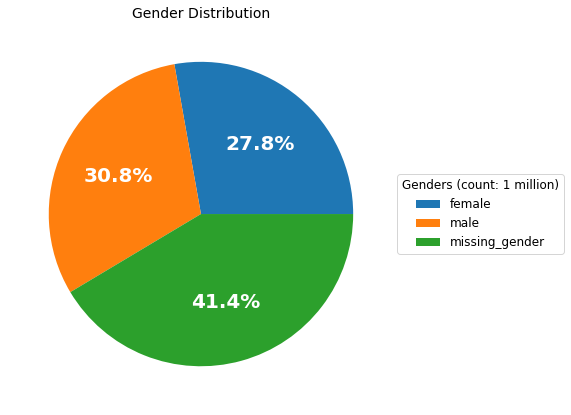

In [5]:
females = len(user_data["female"].nonzero()[0])
males = len(user_data["male"].nonzero()[0])
no_gen = len(user_data["missing_gender"].nonzero()[0])

fig, ax = plt.subplots(figsize=(14, 7), subplot_kw=dict(aspect="equal"))

genders = ["female",
          "male",
          "missing_gender"]

data = [females, males, no_gen]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, genders,
          title="Genders (count: 1 million)",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12, title_fontsize=12)

plt.setp(autotexts, size=20, weight="bold")

ax.set_title("Gender Distribution", fontsize=14)

plt.show()

In [6]:
methods = set(user_data["registered_via"])
n_groups = len(methods)
stds = Counter()
stds.update(user_data["registered_via"])
print(list(stds.values()))

method2churn = {val: 0 for val in list(stds.keys())}

for i, row in user_data.iterrows():
    churn, method = row["is_churn"], row["registered_via"]
    if churn:
        method2churn[method] += 1

[235188, 281670, 93226, 18741, 426]


In [7]:
churn_rate = [list(method2churn.values())[i] / list(stds.values())[i] * 100 for i in range(n_groups)]
churn_rate = [rate / sum(churn_rate) for rate in churn_rate]
churn_rate

[0.1874285824114936,
 0.07572158541975063,
 0.2687122190948933,
 0.3957580771595133,
 0.07237953591434924]

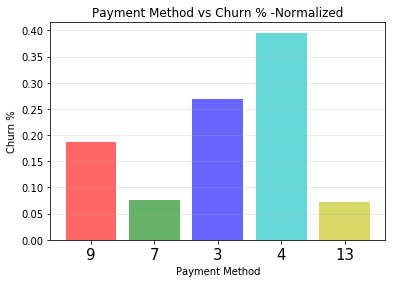

In [8]:
index = np.arange(len(churn_rate))
plt.bar(index, churn_rate, color=['r','g','b','c','y'], alpha=0.6)
plt.xlabel('Payment Method', fontsize=10)
plt.ylabel('Churn %', fontsize=10)
plt.xticks(index, stds.keys(), fontsize=15)
plt.title('Payment Method vs Churn % -Normalized')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [9]:
cities = set(user_data["city"])
num_cities = len(cities)
city_count = Counter()
city_count.update(user_data["city"])
print(list(city_count.values()))

[8182, 97712, 4886, 23596, 44599, 18597, 38634, 67115, 5007, 40954, 10521, 231314, 2499, 6129, 7184, 9341, 6776, 4628, 830, 608, 139]


In [10]:

city2churn = {city: 0 for city in list(city_count.keys())}

for i, row in user_data.iterrows():
    churn, city = row["is_churn"], row["city"]
    if churn:
        city2churn[city] += 1
        
churn_rate = [list(city2churn.values())[i] / list(city_count.values())[i] * 100 for i in range(num_cities)]
# churn_rate = [rate / sum(churn_rate) for rate in churn_rate]
churn_rate

[5.964311904179907,
 6.526322253152121,
 5.894392140810479,
 6.29343956602814,
 6.968766115832194,
 6.269828466957036,
 6.530517161049852,
 6.889666989495642,
 5.432394647493509,
 6.717292572154124,
 8.031555935747553,
 3.6327243487207865,
 5.442176870748299,
 6.917931147006037,
 6.305679287305123,
 6.326945723155979,
 7.246162927981111,
 8.707865168539326,
 5.542168674698795,
 8.05921052631579,
 4.316546762589928]

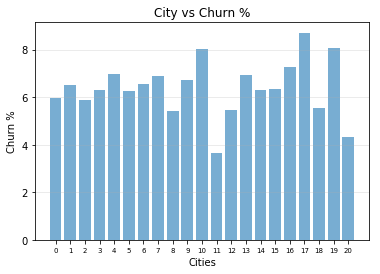

In [11]:
index = np.arange(len(churn_rate))
plt.bar(index, churn_rate, alpha=0.6)
plt.xlabel('Cities', fontsize=10)
plt.ylabel('Churn %', fontsize=10)
plt.xticks(index, fontsize=7)
plt.title('City vs Churn %')
plt.grid(axis='y', alpha=0.3)
plt.show()